In [35]:
import torch
from opacus_new.accountants.utils import get_noise_multiplier

# Example dataset size
n = 5000  # number of samples

# Two distinct batch sizes
batch_size_1 = 500

# Number of epochs
x_1 = 1

# Target DP parameters
epsilon = 2
delta = 0.1

# Compute sample rates
sample_rate_1 = batch_size_1 / n

print(f"Sample rate for batch size {batch_size_1}: {sample_rate_1:.4f}")

# Compute noise multipliers using RDP accountant
noise_multiplier_1 = get_noise_multiplier(
    sample_rate=sample_rate_1,
    steps=x_1 * (n // batch_size_1),
    target_epsilon=epsilon,
    target_delta=delta,
)


print(f"Noise multiplier for batch size {batch_size_1}: {noise_multiplier_1:.4f}")


Sample rate for batch size 500: 0.1000
Noise multiplier for batch size 500: 0.6299


In [36]:
from opacus_new.accountants import RDPAccountant

def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    accountant = RDPAccountant()
    for _ in range(int(iterations)):
        accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = accountant.get_epsilon(delta)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

In [37]:
import numpy as np
deltas = np.logspace(-10, 0, num=300, endpoint=False)
# deltas = np.linspace(1e-10, 1-1e-10, num=100, endpoint=False)
eps1, deltas1 = compute_epsilon_delta(noise_multiplier_1, deltas, x_1 * (n // batch_size_1), sample_rate_1, 1)


In [38]:
def f_eps_delta(alpha, epsilon, delta):
    """Piecewise linear trade-off function f_{ε, δ} (from pure (ε, δ)-DP)."""
    return np.maximum(
        0,
        np.maximum(
            1 - delta - np.exp(epsilon) * alpha,
            np.exp(-epsilon) * (1 - delta - alpha),
        ),
    )

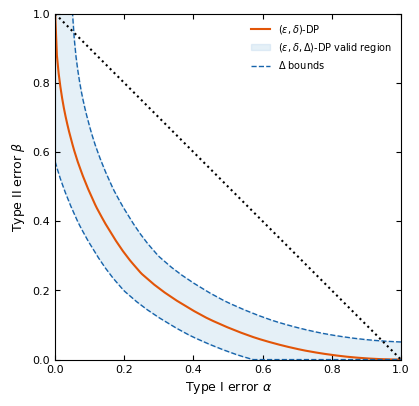

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --------------------
# Parameters
# --------------------
epsilons = eps1
deltas = deltas1
Delta = 0.05
alpha_grid = np.linspace(0, 1, 200)

# --------------------
# Figure setup
# --------------------
fig, ax = plt.subplots(figsize=(4, 4))  # square, suitable for double-column

plt.rcParams.update({
    "font.size": 8,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 7,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.5,
    "axes.linewidth": 0.8
})

# --------------------
# Compute standard DP trade-off curve
# --------------------
f_dp = np.array([f_eps_delta(alpha_grid, eps, delta) for eps, delta in zip(epsilons, deltas)])
f_dp_envelope = np.max(f_dp, axis=0)

# --------------------
# Compute Delta bounding envelopes
# --------------------
f_upper = np.array([
    np.clip(f_eps_delta(np.clip(alpha_grid - Delta, 0, 1), eps, delta) + Delta, 0, 1)
    for eps, delta in zip(epsilons, deltas)
])
f_upper_envelope = np.max(f_upper, axis=0)

f_lower = np.array([
    np.clip(f_eps_delta(np.clip(alpha_grid + Delta, 0, 1), eps, delta) - Delta, 0, 1)
    for eps, delta in zip(epsilons, deltas)
])
f_lower_envelope = np.max(f_lower, axis=0)

# --------------------
# Colors
# --------------------
oranges_cmap = plt.get_cmap('Oranges')
blues_cmap = plt.get_cmap('Blues')

dp_color = oranges_cmap(0.7)        # strong orange for DP curve
fill_color = blues_cmap(0.3)        # light blue for shaded region
line_color = blues_cmap(0.8)        # darker blue for Delta envelopes

# --------------------
# Plot
# --------------------
# Standard DP envelope
dp_line, = ax.plot(alpha_grid, f_dp_envelope, color=dp_color, linewidth=1.5, label=r'($\varepsilon, \delta$)-DP')

# Shaded Delta valid region
shade = ax.fill_between(alpha_grid, f_lower_envelope, f_upper_envelope, color=fill_color,
                        alpha=0.35, label=r'($\varepsilon, \delta, \Delta$)-DP valid region')

# Delta envelopes as dotted lines
lower_line, = ax.plot(alpha_grid, f_lower_envelope, color=line_color, linestyle='--', linewidth=1)
upper_line, = ax.plot(alpha_grid, f_upper_envelope, color=line_color, linestyle='--', linewidth=1, label=r'$\Delta$ bounds')

# Diagonal reference
ax.plot([0, 1], [1, 0], 'k:', label='_nolegend_')

# --------------------
# Labels and styling
# --------------------
ax.set_xlabel(r"Type I error $\alpha$")
ax.set_ylabel(r"Type II error $\beta$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')  # ensures square plot
ax.tick_params(direction="in", top=True, right=True)

# Legend in publication-friendly order
ax.legend(handles=[dp_line, shade, upper_line], fontsize=7, frameon=False)

# --------------------
# Save figure for paper
# --------------------
plt.tight_layout(pad=0.1)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/Delta_bound.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/Delta_bound.svg", dpi=300)
plt.show()
